# Test Image Processing (1366 x 768 pciture)

# Import Library

In [134]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

# Import Raw Photos

In [135]:
img = cv2.imread("../data/photos/raw/test_4.jpg")

if img.shape[1]/img.shape[0] == 1366/768 and img.shape[1] != 1366:
    img = cv2.resize(img, [1366, 768])
elif img.shape[1]/img.shape[0] == 1366/768 and img.shape[1] == 1366:
    pass
else: 
    raise ValueError("The image is not 1366:768")
    
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

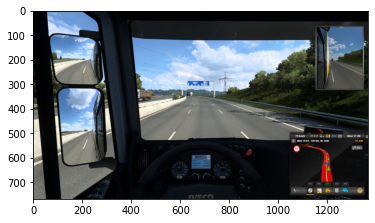

width:   1366
height:  768
channel: 3


In [136]:
plt.imshow(img)
plt.show()
IMAGE_H, IMAGE_W, IMAGE_CHANNELS = img.shape
print('width:  ', IMAGE_W)
print('height: ', IMAGE_H)
print('channel:', IMAGE_CHANNELS)

# Image Pre-Processing

## ROI Cropping

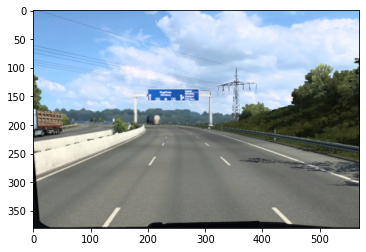

width:   570
height:  380
channel: 3


In [137]:
img_crop = img[150:530, 430:1000] # Apply np slicing for ROI crop
plt.imshow(img_crop)
plt.show()

IMAGE_CROP_H, IMAGE_CROP_W, IMAGE_CROP_CHANNELS = img_crop.shape
print('width:  ', IMAGE_CROP_W)
print('height: ', IMAGE_CROP_H)
print('channel:', IMAGE_CROP_CHANNELS)

## Exposure Correction

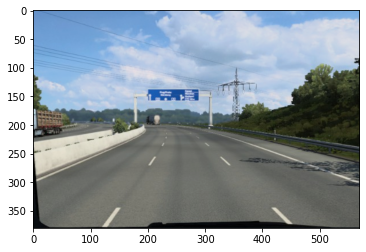

In [138]:
exp_cor = cv2.convertScaleAbs(img_crop, alpha=0.9, beta=0)
plt.imshow(exp_cor)
plt.show()

## Bird Eye View v2

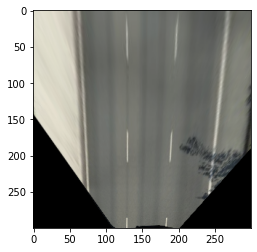

width:   300
height:  300
channel:  3


In [139]:
#Setting up the point for perspective
pts1 = np.float32([[100, IMAGE_CROP_H], [200, 230], [300, 230], [410, IMAGE_CROP_H]])
pts2 = np.float32([[125, 300], [100, 0], [200, 0], [175, 300]])
matrix = cv2.getPerspectiveTransform(pts1, pts2)
matrix_inv = cv2.getPerspectiveTransform(pts2, pts1)

bird_eye = cv2.warpPerspective(exp_cor, matrix, (300,300))
plt.imshow(bird_eye)
plt.show()
IMAGE_BirdEye_H, IMAGE_BirdEye_W, IMAGE_BirdEye_CHANNELS = bird_eye.shape
print('width:  ', IMAGE_BirdEye_H)
print('height: ', IMAGE_BirdEye_W)
print('channel: ', IMAGE_BirdEye_CHANNELS)

# HLS Conversion

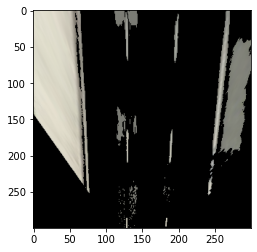

In [140]:
hls = cv2.cvtColor(bird_eye, cv2.COLOR_RGB2HLS)
Lchannel = hls[:,:,1]
mask = cv2.inRange(Lchannel, 120, 255)
hls_res = cv2.bitwise_and(bird_eye,bird_eye, mask= mask)
plt.imshow(hls_res)
plt.show()

# Gray Image

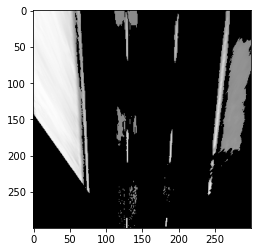

In [141]:
gray = cv2.cvtColor(hls_res,cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap="gray")
plt.show()

## Black and White Conversion

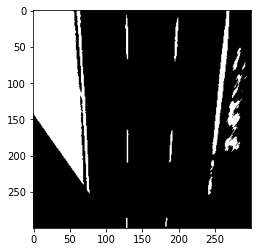

In [142]:
(thresh, black_and_white) = cv2.threshold(gray, 130, 255, cv2.THRESH_BINARY)
plt.imshow(black_and_white, cmap="gray")
plt.show()

# Cropping and Strecth

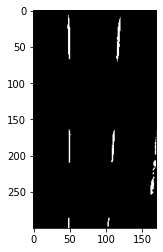

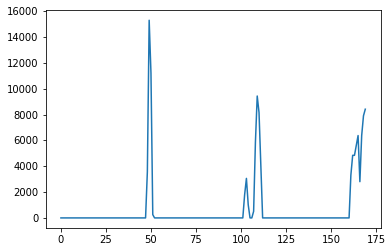

In [154]:
cropped_before_sliding_window = black_and_white[:, 80:250]
plt.imshow(cropped_before_sliding_window, cmap="gray")
plt.show()
histogram = np.sum(cropped_before_sliding_window[cropped_before_sliding_window.shape[0] // 2:, :], axis=0)
plt.plot(histogram)
plt.show()

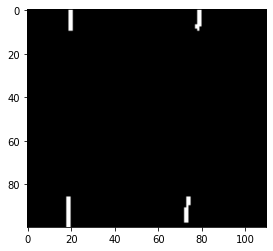

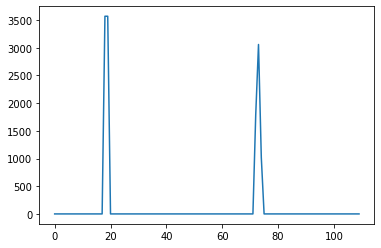

In [161]:
crop_egen = cropped_before_sliding_window[200:cropped_before_sliding_window.shape[0], 30:140]
plt.imshow(crop_egen, cmap="gray")
plt.show()
histogram = np.sum(crop_egen[crop_egen.shape[0] // 2:, :], axis=0)
plt.plot(histogram)
plt.show()

## Sliding Window

<ipython-input-162-b2426081561d>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0] // 2)
<ipython-input-162-b2426081561d>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 

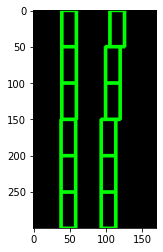

In [162]:
# https://kushalbkusram.medium.com/advanced-lane-detection-fd39572cfe91
# https://github.com/KushalBKusram/AdvancedLaneDetection/blob/master/src/laneDetection.py
def find_lane_pixels(image):
    NILAI_DARI_POJOK_KIRI = 30
    
    
    crop_for_histogram = cropped_before_sliding_window[200:cropped_before_sliding_window.shape[0], NILAI_DARI_POJOK_KIRI:140]
    histogram = np.sum(crop_for_histogram[crop_for_histogram.shape[0] // 2:, :], axis=0)
    out_img = np.dstack((image, image, image)) * 255
    midpoint = np.int(histogram.shape[0] // 2)
    leftx_base = np.argmax(histogram[:midpoint]) + NILAI_DARI_POJOK_KIRI
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint + NILAI_DARI_POJOK_KIRI

    nwindows = 6
    margin = 10
    minpix = 50

    window_height = np.int(image.shape[0] // nwindows)

    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window + 1) * window_height
        win_y_high = image.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 4)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 4)

        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
                    nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
                    nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    # return leftx, lefty, rightx, righty, out_img
    return out_img


g = find_lane_pixels(cropped_before_sliding_window)
plt.imshow(g, cmap="gray")
plt.show()


In [145]:
d

array([287, 287, 288, 288, 289, 289, 290, 291, 291, 292, 292, 293, 293,
       294, 294, 295, 295, 296, 296, 297, 297, 298, 298, 299, 299, 200,
       200, 201, 201, 202, 202, 203, 203, 204, 204, 205, 205, 206, 206,
       207, 207, 208, 208, 209, 209, 210, 210, 211, 211, 212, 212, 213,
       213, 214, 214, 215, 215, 216, 216, 217, 217, 218, 218, 219, 219,
       220, 220, 221, 221, 222, 222, 190, 190, 191, 191, 192, 192, 192,
       193, 193, 193, 194, 194, 194, 195, 195, 195, 196, 196, 196, 197,
       197, 197, 198, 198, 199, 199, 100, 100, 101, 101, 102, 102, 103,
       103, 104, 104, 105, 105, 106, 106, 107, 107, 108, 108, 109, 109,
       110, 110, 111, 111, 112, 112, 113, 113, 114, 114, 115, 115, 116,
       116, 117, 117, 118, 118, 119, 119, 120, 120, 121, 121, 122, 122,
       123, 123, 124, 124, 125, 125, 126,  92,  93,  94,  95,  96,  96,
        97,  97,  98,  98,  99,  99,   2,   3,   4,   5,   6,   7,   8,
         9,  10,  10,  11,  11,  12,  12,  13,  13,  14,  14,  1